In [108]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import f_regression

In [109]:
team_stats = pd.read_csv("../data/team_stats_1.csv")
team_stats_df = pd.DataFrame(team_stats.ix[:,1:9])
team_stats_df.head()

,Cfperc,Ffperc,PDO,Foperc,oiSHperc,oZSperc,Playoff,ConfFinal
0,0.527,0.524,0.989,0.494,0.093,0.537,0,0
1,0.591,0.592,0.996,0.533,0.089,0.605,1,1
2,0.512,0.512,0.983,0.498,0.090,0.528,0,0
3,0.539,0.550,0.991,0.523,0.079,0.589,1,0
4,0.529,0.536,0.994,0.512,0.094,0.534,1,0


In [110]:
team_stats_df.describe()

,Cfperc,Ffperc,PDO,Foperc,oiSHperc,oZSperc,Playoff,ConfFinal
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,0.499456,0.500081,1.000056,0.499956,0.090604,0.510752,0.474074,0.118519
std,0.027959,0.027741,0.011996,0.019997,0.008479,0.027373,0.500255,0.323821
min,0.380000,0.393000,0.963000,0.442000,0.069000,0.424000,0.000000,0.000000
25%,0.480250,0.482000,0.993000,0.486000,0.085000,0.494000,0.000000,0.000000
50%,0.501500,0.502000,1.001000,0.501000,0.091000,0.512000,0.000000,0.000000
75%,0.520000,0.520000,1.007000,0.513000,0.096000,0.527750,1.000000,0.000000
max,0.591000,0.592000,1.033000,0.564000,0.116000,0.605000,1.000000,1.000000


In [111]:
features=list(team_stats_df.columns)[0:-2]

In [112]:
import itertools
feature_list = []
for i in range(1,len(features)+1):
    for j in itertools.combinations(features,i):
        feature_list.append(list(j))

### Starting off with logistic regression.
#### We're going to do models for both the playoffs and the conference finals as our dependent variable.

In [113]:
def make_playoff(features):
    model = LogisticRegression()
    X = team_stats_df[features]
    Y = team_stats_df["Playoff"]
    logmod = model.fit(X,Y)
    score = get_score(logmod,X,Y)
    result = [score, features]
    return result

In [114]:
def get_params(features):
    model = LogisticRegression()
    X = team_stats_df[features]
    Y = team_stats_df["Playoff"]
    logmod = model.fit(X,Y)
    coefs = logmod.coef_
    inter = logmod.intercept_
    pvallong = f_regression(X,Y)[1]
    pval = [i*100.0 for i in pvallong]
    return coefs, inter, pval

#### <font color="red">Please note that depending on the training and cross validation method, the optimal model may change.</em></font>

In [115]:
def get_score(model,x,y):
    #Keep Random State = 1000 to make sure repeatable results
    shuffle=ShuffleSplit(len(x),n_iter=5,test_size=0.2, random_state=1000)
    scores = cross_val_score(model,x,y,scoring="roc_auc",cv=shuffle)
    result = scores.mean()
    return result

In [116]:
rank=[]
for i in feature_list:
    rank.append(make_playoff(i))

In [117]:
rank.sort()
rank = rank[-5:]
rank_num = 5
print("Here are the models and our ROC-AUC score for the five best models. We'll need \n "\
      "to check the collinearity (remember what we did in the data mgmt file?)\n")
for i in rank:
    print("Model #%d: " % rank_num, i)
    rank_num -=1

Here are the models and our ROC-AUC score for the five best models. We'll need 
 to check the collinearity (remember what we did in the data mgmt file?)

('Model #5: ', [0.80914928670295472, ['Ffperc']])
('Model #4: ', [0.81080543113629455, ['Ffperc', 'PDO']])
('Model #3: ', [0.81187302886375079, ['Ffperc', 'Foperc', 'oiSHperc']])
('Model #2: ', [0.81406469713031948, ['Ffperc', 'PDO', 'oiSHperc']])
('Model #1: ', [0.81522548589594646, ['Ffperc', 'oiSHperc']])


In [118]:
team_stats_corr = team_stats_df.corr(method="pearson")
(team_stats_corr > .75) | (team_stats_corr<(-.75))

,Cfperc,Ffperc,PDO,Foperc,oiSHperc,oZSperc,Playoff,ConfFinal
Cfperc,True,True,False,False,False,True,False,False
Ffperc,True,True,False,False,False,True,False,False
PDO,False,False,True,False,False,False,False,False
Foperc,False,False,False,True,False,False,False,False
oiSHperc,False,False,False,False,True,False,False,False
oZSperc,True,True,False,False,False,True,False,False
Playoff,False,False,False,False,False,False,True,False
ConfFinal,False,False,False,False,False,False,False,True


#### Looking at the variables in our models, we see that there is no colinearity.

#### <font color="red">Running via SciKit to see where models could be useful, going to use statsmodels for summary and analysis purposes.<em> see below  </em></font>

In [119]:
mods = range(0,5)
param_list = []
coefs = []
for i in mods:
    param_list.append(rank[i][1])
for i in param_list:
    coefs.append(get_params(i))
results = pd.DataFrame(coefs, columns=["Coefficients","Intercept","Pvals"])
results

,Coefficients,Intercept,Pvals
0,[[1.25053231784]],[-0.718521551826],[9.00596462977e-13]
1,"[[1.24356069599, 0.0179544324121]]",[-0.73277701482],"[9.00596462977e-13, 8.16290607946e-14]"
2,"[[1.20044599291, 0.211612067474, 0.218476766433]]",[-0.817595349126],"[9.00596462977e-13, 0.00663360195854, 0.002261..."
3,"[[1.23982811431, 0.00825631725208, 0.225164047...",[-0.741482193085],"[9.00596462977e-13, 8.16290607946e-14, 0.00226..."
4,"[[1.24319491736, 0.225815844043]]",[-0.735065914912],"[9.00596462977e-13, 0.00226187741951]"


In [120]:
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn import dummy

#### <font color="red">Going to ignore sklearn to focus on statsmodels. <em>Leaving code just incase we change our mind later</em></font>

In [121]:
# baseline = dummy.DummyClassifier()
# baseline.fit(team_stats_df[['Cfperc', 'PDO', 'Foperc', 'oiSHperc']],team_stats_df["Playoff"])
# team_stats_df["baseline"]=baseline.predict_proba(team_stats_df[['Cfperc', 'PDO', 'Foperc', 'oiSHperc']]).T[1]
# predictions = LogisticRegression()
# predictions.fit(team_stats_df[['Cfperc', 'PDO', 'Foperc', 'oiSHperc']], team_stats_df['Playoff'])
# team_stats_df['predictions'] = predictions.predict_proba(team_stats_df[['Cfperc', 'PDO', 'Foperc', 'oiSHperc']]).T[1]

In [122]:
# team_stats_df
# fig = plt.figure(figsize=(6,6))
# axes = fig.add_subplot(1,1,1,xlim=(0,100))
# #Had issues making a good baseline curve
# #val_1 = roc_curve(team_stats_df["Playoff"],team_stats_df['baseline'])[1]
# val_1 = [x/100.0 for x in range(0,101)]
# val_2 = roc_curve(team_stats_df["Playoff"],team_stats_df['predictions'])[1]
# thresh = roc_curve(team_stats_df["Playoff"],team_stats_df['predictions'])[2]
# axes.plot(val_2)
# axes.plot(val_1)
# axes.set(title='ROC curve for making playoffs', ylabel='True Positive Rate', xlabel='')

#### Since SciKit is pretty aweful at making a good looking summary, we're going to make the models again with stats models to print out the data.

In [123]:
import statsmodels.api as sm
#Bring in intercept
team_stats_df["intercept"]=1
team_stats_df = team_stats_df[['intercept','Cfperc','Ffperc','PDO','Foperc','oiSHperc','oZSperc','Playoff','ConfFinal']]

In [124]:
for i in param_list:
    i.insert(0,"intercept")
    print i

['intercept', 'Ffperc']
['intercept', 'Ffperc', 'PDO']
['intercept', 'Ffperc', 'Foperc', 'oiSHperc']
['intercept', 'Ffperc', 'PDO', 'oiSHperc']
['intercept', 'Ffperc', 'oiSHperc']


In [125]:
#In the future, let's try turning this into a pipeline.
def stats_logit(features):
    logit_mod = sm.Logit(team_stats_df["Playoff"],team_stats_df[features])
    logit_res = logit_mod.fit()
    print(logit_res.summary())

In [126]:
for i in param_list:
    stats_logit(i)

Optimization terminated successfully.
         Current function value: 0.577197
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Playoff   No. Observations:                  270
Model:                          Logit   Df Residuals:                      268
Method:                           MLE   Df Model:                            1
Date:                Fri, 25 Mar 2016   Pseudo R-squ.:                  0.1657
Time:                        13:25:48   Log-Likelihood:                -155.84
converged:                       True   LL-Null:                       -186.79
                                        LLR p-value:                 3.638e-15
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
intercept    -21.2257      3.173     -6.689      0.000       -27.445   -15.006
Ffperc        42.1692      6.

## <font color="Orange">Our models give us a variety of results. However, we're going to focus on the models with the best adjusted R-Squared results which are models two and four. Or the set using the variables Fenwick For, PDO and offiensive shooting percentage and the model containing fenwick for and PDO. Upon further analysis we see that Offensive shooting percentage is non statistically significant and only slightly improves the log liklihood and R-squared.</font>
<ul>
    <li>Now we want to look at the probabilities
    <li>Then we can make a rock curve
    <li>Look at a confusion matrix
    <li>Try and alternative model
</ul></font>


In [152]:
final_feat = ["PDO","Ffperc","intercept"]
result_mod = sm.Logit(team_stats_df["Playoff"],team_stats_df[final_feat])
result_fit = logit_mod.fit()
predictions = pd.DataFrame(result_fit.pred_table(), columns=["No_Actual","Yes_Pred"],index=["No_Pred","Yes_Actual"])
predictions

Optimization terminated successfully.
         Current function value: 0.369860
         Iterations 8


,No_Actual,Yes_Pred
No_Pred,119,23
Yes_Actual,20,108


#### As we can see from our confusion matrix above, we actually did a pretty good job of predicting playoff acceptance. Now let's look at a ROC Curve: http://nbviewer.jupyter.org/urls/umich.box.com/shared/static/aouhn2mci77opm3v89vc.ipynb

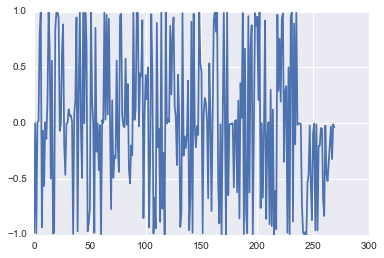

In [177]:
scores = np.zeros(team_stats_df.shape[0], dtype=np.float64)
for k in range(np.zeros(team_stats_df.shape[0])
#results = result_fit.predict(team_stats_df[final_feat])

# We need to explain the probabilities in this for each variable